<a href="https://colab.research.google.com/github/aksoym/Machine-Learning/blob/master/AksoyMProject_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# UUM625 Project 2
##ESTIMATION OF THE TOTAL FUEL FLOW RATE OF A JET AIRCRAFT USING DEEP REGRESSION MODELS

###A template is used as the core structure of the following code. Template is provided by Mevlüt Uzun in the course UUM625 at ITU.

####Prepared by Muhammet Aksoy

**Using the provided template to mount the drive and install libraries**

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

!mkdir -p drive
!google-drive-ocamlfuse drive
!ls drive/

In [0]:
!pip install imbalanced-learn
!pip install livelossplot
!pip install -U scikit-learn
!pip install joblib

In [3]:
# Keras Libraries
from keras.layers import Input, Dense, Dropout
from keras.models import Model, load_model
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from livelossplot import PlotLossesKeras
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam, SGD
from keras import backend as k
from keras.utils import multi_gpu_model
import tensorflow as tf
import random as rn
import os
import scipy.io as sio

# Pandas Libraries
import pandas as pd

# Numpy Libraries
import numpy as np
np.random.seed(27)

# File IO Libraries
import glob
import scipy.io as sio

# Plotting Libraries
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

TOOLS = "pan,wheel_zoom,box_zoom,reset,save,box_select"

# Data Preparation Libraries
from sklearn import model_selection
from sklearn import preprocessing
import joblib
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

os.environ['PYTHONHASHSEED'] = '0'

# Same pseudo-random number seed will be used everytime the code is run. This is to keep the things unchanged when the code is being run several times to re-evaluate.
np.random.seed(27)
rn.seed(27)
tf.set_random_seed(27)

sess = tf.Session(graph=tf.get_default_graph())
k.set_session(sess)

Using TensorFlow backend.


**Data Examination**

In [6]:
#Reading the datasets.
dataset_1 = pd.read_pickle("/content/drive/DeepLearning/Project_2/DataSet1")
dataset_2 = pd.read_pickle("/content/drive/DeepLearning/Project_2/DataSet2")

dataset_1.head(3)

,Altitude (ft),Heading (deg),CAS (kt),Ground Speed (kt),Mach,Temp (C),Mass (kg),Apu Fuel (lb/hr),FF1 (lb/hr),FF2 (lb/hr),Throttle 1,Throttle 2,Course (deg),Wind Direction (deg),Wind Speed (kt),Flap (deg),Landing Gear,Speed Break,Zero Fuel Weight (lbs),Fuel Onboard (kg),Air Pressure (mb),Ground Speed Dot (kt/s2),Altitude Dot (ft/s),Heading Dot (deg/s),True Airspeed (m/s),True Airspeed Dot (m/s2),Gamma (rad),Drag (N),Thrust (N)
0,0.0,0.0,0.00,0.0,0.0000,0.00,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000e+00
1,139.0,263.0,130.13,121.0,0.1995,20.50,337140.125583,238.0,37264.0,36208.0,79.72,79.72,263.0,-97.0,10.63,15.0,1.0,0.0,507200.0,107100.0,1006.0,4.0,0.0,0.0,68.515987,1.874518,0.000000,492526.970794,1.124502e+06
2,139.0,263.0,132.88,125.0,0.2050,20.38,337130.850423,238.0,37184.0,36192.0,79.72,79.72,263.0,-96.0,9.50,15.0,1.0,0.0,507200.0,107050.0,1006.0,4.0,0.5,0.0,70.390504,2.139048,0.002165,468451.878186,1.196749e+06


In [7]:
dataset_2.head(3)

,Altitude (ft),Heading (deg),CAS (kt),Ground Speed (kt),Mach,Temp (C),Mass (kg),Apu Fuel (lb/hr),FF1 (lb/hr),FF2 (lb/hr),Throttle 1,Throttle 2,Course (deg),Wind Direction (deg),Wind Speed (kt),Flap (deg),Landing Gear,Speed Break,Zero Fuel Weight (lbs),Fuel Onboard (kg),Air Pressure (mb),Ground Speed Dot (kt/s2),Altitude Dot (ft/s),Heading Dot (deg/s),True Airspeed (m/s),True Airspeed Dot (m/s2),Gamma (rad),Drag (N),Thrust (N)
0,0.0,0.0,0.00,0.0,0.0000,0.00,0.000000,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000e+00
1,140.0,263.0,131.63,125.0,0.2025,18.25,325554.611609,238.0,31984.0,32544.0,75.19,75.32,263.0,-93.0,8.13,15.0,1.0,1.0,476160.0,109700.0,1008.0,3.0,0.0,0.0,69.279215,2.551095,0.0,485283.286925,1.315804e+06
2,140.0,263.0,136.63,128.0,0.2100,18.13,325546.449257,238.0,31968.0,32576.0,75.19,75.32,263.0,-92.0,9.38,15.0,1.0,1.0,476160.0,109700.0,1008.0,3.5,0.0,0.0,71.830310,2.301695,0.0,460186.379745,1.209495e+06


In [8]:
#Checking to see if there is any missing value.
print (dataset_1.isnull().values.any(), dataset_2.isnull().values.any(), sep="\n")
#Getting rid of the empty rows.
dataset_1 = dataset_1[dataset_1["Mass (kg)"] != 0]
dataset_2 = dataset_2[dataset_2["Mass (kg)"] != 0]
dataset_2.shape #There was only 1 empty row.

False
False


(375378, 29)

**Visualization**

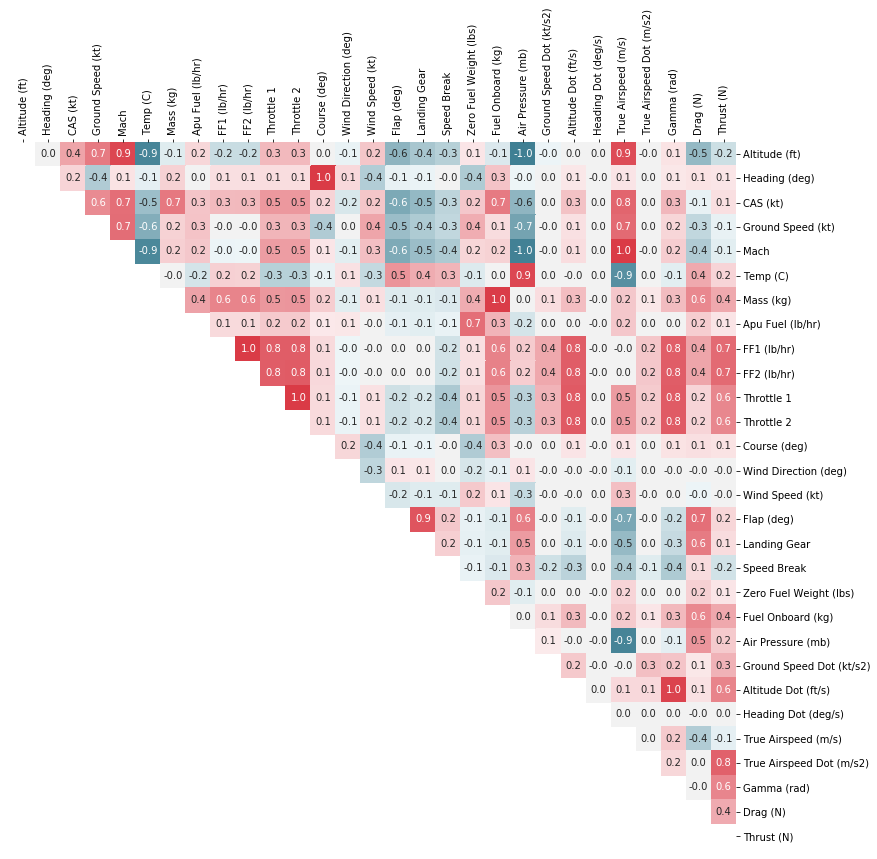

In [9]:
#Correlation matrix for DataSet1.    
cm = dataset_1.corr()
fig, ax = plt.subplots(figsize=(13, 13))
dropSelf = np.zeros_like(cm)
dropSelf[np.tril_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap=True)
plt.xticks(np.arange(0.5, len(cm.columns), 1), cm.columns)
plt.yticks(np.arange(0.5, len(cm.columns), 1), cm.columns)
ax.yaxis.tick_right()
ax.xaxis.tick_top()
sns.heatmap(cm, cmap=colormap, annot=True, fmt=".1f", mask=dropSelf, cbar=False)
plt.show()

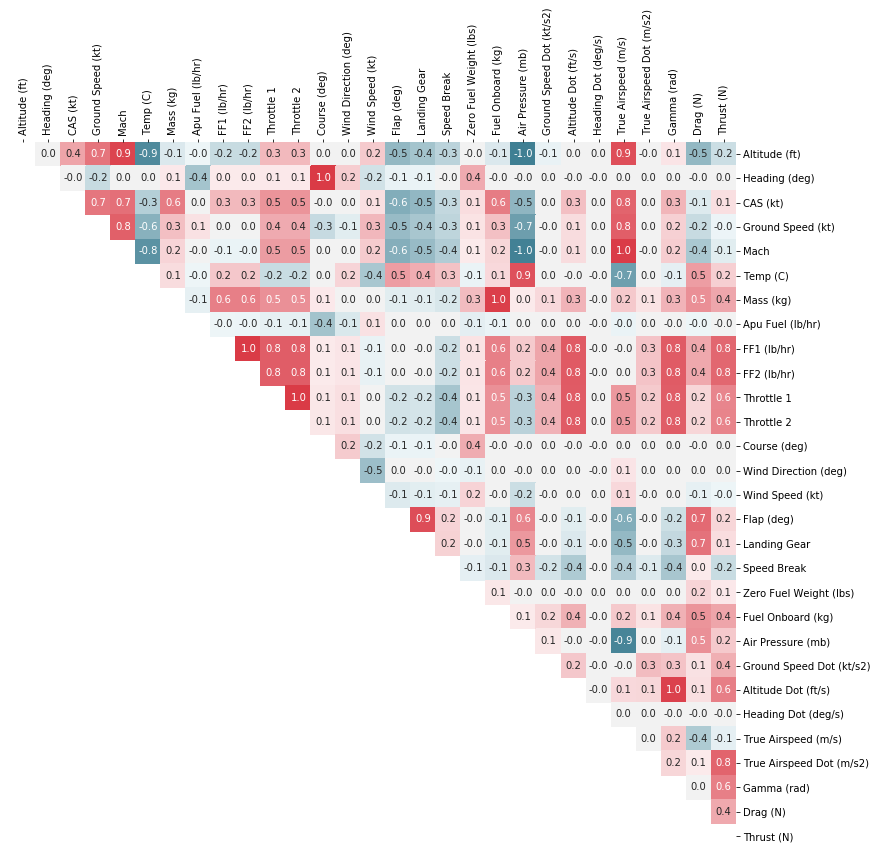

In [10]:
#Correlation matrix for DataSet2.    
cm = dataset_2.corr()
fig, ax = plt.subplots(figsize=(13, 13))
dropSelf = np.zeros_like(cm)
dropSelf[np.tril_indices_from(dropSelf)] = True
colormap = sns.diverging_palette(220, 10, as_cmap=True)
plt.xticks(np.arange(0.5, len(cm.columns), 1), cm.columns)
plt.yticks(np.arange(0.5, len(cm.columns), 1), cm.columns)
ax.yaxis.tick_right()
ax.xaxis.tick_top()
sns.heatmap(cm, cmap=colormap, annot=True, fmt=".1f", mask=dropSelf, cbar=False)
plt.show()

**Preperation of dataset_1**

In [0]:
#Converting FF1 and FF2 to kg/s and to Total-Fuel-Flow.
dataset_1['TFF (kg/s)'] = ((dataset_1['FF1 (lb/hr)'] + dataset_1['FF2 (lb/hr)'])/(7936.641))
 

#First stage; 6 features to 1 target.
x_features1 = np.column_stack( (dataset_1['Throttle 1'], dataset_1['Throttle 2'], dataset_1['Gamma (rad)'], dataset_1['Altitude Dot (ft/s)'], dataset_1['Thrust (N)'], dataset_1["Mass (kg)"]) )
#Second stage; dropping throttle positions.
x_features2 = np.column_stack( (dataset_1['Gamma (rad)'], dataset_1['Altitude Dot (ft/s)'], dataset_1['Thrust (N)'], dataset_1["Mass (kg)"]) )
#Third stage; finding proper features to replace throttle positions. Adding "Drag", "True Airspeed Dot" and "Fuel Onboard (kg)".
x_features3 = np.column_stack( (dataset_1['Drag (N)'], dataset_1['True Airspeed Dot (m/s2)'], dataset_1['Gamma (rad)'], dataset_1['Altitude Dot (ft/s)'],
                                dataset_1['Thrust (N)'], dataset_1["Mass (kg)"], dataset_1["Fuel Onboard (kg)"]) )

# Target array for the first 3 stages.(kg/s).
y_target = np.array(dataset_1["TFF (kg/s)"])
y_target = y_target.reshape(-1, 1)  
  

#Fourth stage; splitting datasets to climb, cruise and descent phases.
climb_phase = dataset_1[dataset_1['Altitude Dot (ft/s)'] > 0]
cruise_phase = dataset_1[dataset_1['Altitude Dot (ft/s)'] == 0]
descent_phase = dataset_1[dataset_1['Altitude Dot (ft/s)'] < 0]

x_features4 = np.column_stack( (climb_phase['Throttle 1'], climb_phase['Throttle 2'], climb_phase['Gamma (rad)'], climb_phase['Altitude Dot (ft/s)'], climb_phase['Thrust (N)'], climb_phase["Mass (kg)"]) )

x_features5 = np.column_stack( (cruise_phase['Throttle 1'], cruise_phase['Throttle 2'], cruise_phase['Gamma (rad)'], cruise_phase['Altitude Dot (ft/s)'], cruise_phase['Thrust (N)'], cruise_phase["Mass (kg)"]) )

x_features6 = np.column_stack( (descent_phase['Throttle 1'], descent_phase['Throttle 2'], descent_phase['Gamma (rad)'], descent_phase['Altitude Dot (ft/s)'], descent_phase['Thrust (N)'], descent_phase["Mass (kg)"]) )

#Fourth stage target arrays.
y_target4 = np.array(climb_phase["TFF (kg/s)"])
y_target4 = y_target4.reshape(-1, 1)

y_target5 = np.array(cruise_phase["TFF (kg/s)"])
y_target5 = y_target5.reshape(-1, 1)

y_target6 = np.array(descent_phase["TFF (kg/s)"])
y_target6 = y_target6.reshape(-1, 1)



**Preparation of dataset_2**

In [0]:
#Converting FF1 and FF2 to kg/s and to Total-Fuel-Flow.
dataset_2['TFF (kg/s)'] = ((dataset_2['FF1 (lb/hr)'] + dataset_2['FF2 (lb/hr)'])/(7936.641))
 

#First stage; 6 features to 1 target.
ds2_features1 = np.column_stack( (dataset_2['Throttle 1'], dataset_2['Throttle 2'], dataset_2['Gamma (rad)'], dataset_2['Altitude Dot (ft/s)'], dataset_2['Thrust (N)'], dataset_2["Mass (kg)"]) )
#Second stage; dropping throttle positions.
ds2_features2 = np.column_stack( (dataset_2['Gamma (rad)'], dataset_2['Altitude Dot (ft/s)'], dataset_2['Thrust (N)'], dataset_2["Mass (kg)"]) )
#Third stage; finding proper features to replace throttle positions. Adding "Drag", "True Airspeed Dot" and "Fuel Onboard (kg)".
ds2_features3 = np.column_stack( (dataset_2['Drag (N)'], dataset_2['True Airspeed Dot (m/s2)'], dataset_2['Gamma (rad)'], dataset_2['Altitude Dot (ft/s)'],
                                dataset_2['Thrust (N)'], dataset_2["Mass (kg)"], dataset_2["Fuel Onboard (kg)"]) )

# Target array for the first 3 stages.(kg/s).
ds2_target = np.array(dataset_2["TFF (kg/s)"])
ds2_target = ds2_target.reshape(-1, 1)  
  

#Fourth stage; splitting datasets to climb, cruise and descent phases.
climb_phase = dataset_2[dataset_2['Altitude Dot (ft/s)'] > 0]
cruise_phase = dataset_2[dataset_2['Altitude Dot (ft/s)'] == 0]
descent_phase = dataset_2[dataset_2['Altitude Dot (ft/s)'] < 0]

ds2_features4 = np.column_stack( (climb_phase['Throttle 1'], climb_phase['Throttle 2'], climb_phase['Gamma (rad)'], climb_phase['Altitude Dot (ft/s)'], climb_phase['Thrust (N)'], climb_phase["Mass (kg)"]) )

ds2_features5 = np.column_stack( (cruise_phase['Throttle 1'], cruise_phase['Throttle 2'], cruise_phase['Gamma (rad)'], cruise_phase['Altitude Dot (ft/s)'], cruise_phase['Thrust (N)'], cruise_phase["Mass (kg)"]) )

ds2_features6 = np.column_stack( (descent_phase['Throttle 1'], descent_phase['Throttle 2'], descent_phase['Gamma (rad)'], descent_phase['Altitude Dot (ft/s)'], descent_phase['Thrust (N)'], descent_phase["Mass (kg)"]) )

#Fourth stage target arrays.
ds2_target4 = np.array(climb_phase["TFF (kg/s)"])
ds2_target4 = ds2_target4.reshape(-1, 1)

ds2_target5 = np.array(cruise_phase["TFF (kg/s)"])
ds2_target5 = ds2_target5.reshape(-1, 1)

ds2_target6 = np.array(descent_phase["TFF (kg/s)"])
ds2_target6 = ds2_target6.reshape(-1, 1)

**Train - Test Split**

In [0]:
#Splitting the dataset.
X_train, X_test, y_train, y_test = train_test_split(ds2_features6, ds2_target6, test_size=0.2, shuffle=True)

#Choosing the scaler.
scaler1 = preprocessing.StandardScaler()
scaler2 = preprocessing.StandardScaler()

#Scaling the values.
sc1 = scaler1.fit( X_train )
x_train_sc = sc1.transform( X_train )
x_test_sc = sc1.transform( X_test )
           
sc2 = scaler2.fit( y_train )
y_train_sc = sc2.transform( y_train )
y_test_sc = sc2.transform( y_test )
             

**Architecture of the Network**

In [0]:
k.clear_session() # Keep this line of code here to reset your networks parameters.

# The number of inputs (features) on our input layer.
n_dims = X_train.shape[1]

# Defining the input layer with the shape n_dims.
aircraft_measurements = Input(shape=(n_dims,))

# Hidden layers.
L1 = Dense(1024, activation="relu",
         kernel_initializer= "glorot_uniform", bias_initializer="zeros")(aircraft_measurements)
L2 = Dense(1024, activation="relu",
          kernel_initializer="glorot_uniform", bias_initializer="zeros")(L1)
L3 = Dense(1024, activation="relu",
          kernel_initializer= "glorot_uniform", bias_initializer="zeros")(L2)




# Defining the output layer. Shape = number of targets.
fuel_flow = Dense(y_train_sc.shape[1], kernel_initializer="random_uniform")(L3)

# State input and output layers. The model will connect the necessary layers accordingly.
model = Model(inputs=[aircraft_measurements], outputs=[fuel_flow])

# Selection of optimizer and loss function.
model.compile(optimizer="adam", loss="mean_squared_error" )

# Create a filename for your best model
model_name = 'my_model.hdf5'

path="drive/DeepLearning/" + model_name
checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, period=1, mode='min')

**Model Training**

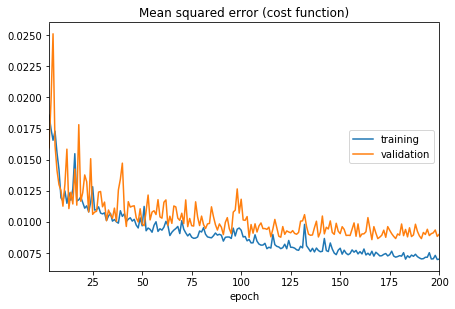

Mean squared error (cost function):
training   (min:    0.007, max:    0.048, cur:    0.007)
validation (min:    0.009, max:    0.025, cur:    0.009)

Epoch 00200: loss did not improve from 0.00697


In [0]:
num_epochs = 200
batch_size = 512
validation_size = 0.2

history = model.fit(x_train_sc, y_train_sc, 
                    batch_size=batch_size, epochs=num_epochs, shuffle=True, 
                    validation_split=validation_size, callbacks=[PlotLossesKeras(), checkpoint])

In [0]:
# Load the model with best results
model = load_model(path)

# Make the prediction
y_predicted = model.predict(x_test_sc)

# Take inverse transform of your prediction (because it is scaled!)
y_predicted_inv = sc2.inverse_transform( y_predicted )

In [0]:
mae = str(np.round(mean_absolute_error(y_predicted_inv, y_test), 4))
print("Mean absolute error is :  " + mae + " (kg/s)")

Mean absolute error is :  0.0422 (kg/s)
